# Data Tokenization

## Pitch Class Chord Tokenization

Let's represent each chord as a binary vector of 12 elements, with each element representing the presence or absence of that note in the chord without considering octaves. Chords that are mapped to identical vectors will be using the same token.

In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns

import chord_parser

In [2]:
with open("Data/chord_map.json", "r") as fp:
    chord_map = json.load(fp) # Contains all chords and their corresponding notes, extracted during EDA
    
data = pd.read_csv('Data/data_cleaned.csv')
data.head()

,url,title,artist,decade,genre,ratings,stars,chords
0,https://tabs.ultimate-guitar.com/tab/jeff-buck...,Hallelujah,Jeff Buckley,1990,Rock|Folk,51639.0,5.0,C Am C Am C Am C Am F G C G C F G Am F G E7 Am...
1,https://tabs.ultimate-guitar.com/tab/ed-sheera...,Perfect,Ed Sheeran,2010,Pop,44194.0,5.0,G Em C D G Em C D G Em C G D G Em C D Em C G D...
2,https://tabs.ultimate-guitar.com/tab/elvis-pre...,Cant Help Falling In Love,Elvis Presley,1960,"Soundtrack|R&B, Funk & Soul",30059.0,5.0,C G Am F C G C Em Am F C G F G Am F C G C Em A...
3,https://tabs.ultimate-guitar.com/tab/eagles/ho...,Hotel California,Eagles,1970,Rock,28670.0,5.0,Bm F#7 A E G D Em F#7 Bm F#7 A E G D Em F#7 Bm...
4,https://tabs.ultimate-guitar.com/tab/radiohead...,Creep,Radiohead,1990,Rock,28606.0,5.0,G B C Cm G B C Cm G B C Cm G B C Cm G B C Cm G...


In [3]:
parser = chord_parser.Main()

We want to represent the chords as vectors and store them as keys to a dictionary, so we will convert them to strings with ones and zeros. Let's also apply the transpositions to make the future model adaptable to all variants.

In [4]:
# This method will be used for transposition
def roll_string(s, shift):
    return s[-shift:] + s[:-shift]

# Initialization
all_chord_reps = set() # Contains all the possible chord representations
chord_to_notes, notes_to_chord = {}, {}
all_notes = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
    
for chord, chord_notes in chord_map.items():
    # Get the normalized chord notes (ignoring octave and the root note)
    chord_notes = np.array(chord_notes)
    chord_notes = np.sort((chord_notes - chord_notes.min()) % 12)

    # Create a one-hot representation of the chord
    hot_notes = np.zeros(12)
    hot_notes[chord_notes] = 1
    
    # Convert the one-hot representation to a string
    str_notes = "".join([str(int(i)) for i in hot_notes])

    # Parse the chord extension
    root, ext = parser.get_root_and_ext(chord)
    ext = parser.update_if_slash(root, ext)

    # For the extension, we need to get all the possible transpositions
    for i in range(12):
        # Transpose the notes
        transposed_str_notes = roll_string(str_notes, i)
        
        # Add the new chord to the set
        all_chord_reps.add(transposed_str_notes)
        chord_to_notes[all_notes[i] + ext] = transposed_str_notes
        notes_to_chord[transposed_str_notes] = all_notes[i] + ext

# Sort the chord representations for consistency
all_chord_reps = sorted(list(all_chord_reps))
rep_to_token = {ext: i for i, ext in enumerate(all_chord_reps)}

# The inverse should contain the most simple chord representation
for chord, notes in chord_to_notes.items():
    if len(notes_to_chord[notes]) > len(chord):
        if "/I" != chord[-2:]: # Fixes a bug with the slash chords
            notes_to_chord[notes] = chord

token_to_chord = [notes_to_chord[rep] for rep in all_chord_reps]

In [5]:
print(f"There are a total of {len(all_chord_reps)} unique chord representations.")

There are a total of 973 unique chord representations.


During the training of the model, we would also like to use augmentation, so we will create a map that will return all possible transpositions for each token.

In [6]:
# Create the augmentation map
augmentation_map = []
for i, rep in enumerate(all_chord_reps):
    orig = rep_to_token[roll_string(rep, 0)]
    augmentations = []
    for j in range(0, 12):
        augmentations.append(rep_to_token[roll_string(rep, j)])
    augmentation_map.append(np.array(augmentations))

augmentation_map = np.array(augmentation_map)

While parsing the data, we will need to account for the variants of the notes, such as Db instead of C# or E# instead of F. Therefore, we will create a note map to convert them to the sharp variant. We will use the music21 library for easier map creation.

In [7]:
import music21 as m21

mods = ["--", "-", "", "#", "##"]
note_names = ["C", "D", "E", "F", "G", "A", "B"]
note_map = {}
for note in note_names:
    for mod in mods:
        p = m21.pitch.Pitch(note + mod)
        enharmonics = p.getAllCommonEnharmonics()
        enharmonics.append(p)
        for enh in enharmonics:
            enh = str(enh)
            if enh in all_notes:
                note_map[note + mod] = enh

# Does not also add C-- and F--
note_map["C--"] = "A#"
note_map["F--"] = "D#"

In [8]:
# Works on all chords from the dataset
def get_chord_token(chord):
    root, ext = parser.get_root_and_ext(chord)
    ext = parser.update_if_slash(root, ext)
    return rep_to_token[chord_to_notes[note_map[root] + ext]]

In [9]:
# Save rep_to_token and token_to_chord, as well as the augmentation map
with open('Data/rep_to_token.json', 'w') as fp:
    json.dump(rep_to_token, fp)
with open('Data/token_to_chord.json', 'w') as fp:
    json.dump(token_to_chord, fp)
np.save("Data/augmentation_map.npy", augmentation_map)

Let's tokenize the data.

In [10]:
def tokenize_chords(chords):
    chords = [get_chord_token(ch) for ch in chords.strip().split(" ")]
    return np.array(chords, dtype=np.int32)

# Takes a while to run
data["chords_rep"] = data["chords"].apply(tokenize_chords)

In [11]:
data.head()

,url,title,artist,decade,genre,ratings,stars,chords,chords_rep
0,https://tabs.ultimate-guitar.com/tab/jeff-buck...,Hallelujah,Jeff Buckley,1990,Rock|Folk,51639.0,5.0,C Am C Am C Am C Am F G C G C F G Am F G E7 Am...,"[648, 640, 648, 640, 648, 640, 648, 640, 617, ..."
1,https://tabs.ultimate-guitar.com/tab/ed-sheera...,Perfect,Ed Sheeran,2010,Pop,44194.0,5.0,G Em C D G Em C D G Em C G D G Em C D Em C G D...,"[155, 31, 648, 169, 155, 31, 648, 169, 155, 31..."
2,https://tabs.ultimate-guitar.com/tab/elvis-pre...,Cant Help Falling In Love,Elvis Presley,1960,"Soundtrack|R&B, Funk & Soul",30059.0,5.0,C G Am F C G C Em Am F C G F G Am F C G C Em A...,"[648, 155, 640, 617, 648, 155, 648, 31, 640, 6..."
3,https://tabs.ultimate-guitar.com/tab/eagles/ho...,Hotel California,Eagles,1970,Rock,28670.0,5.0,Bm F#7 A E G D Em F#7 Bm F#7 A E G D Em F#7 Bm...,"[166, 403, 380, 26, 155, 169, 31, 403, 166, 40..."
4,https://tabs.ultimate-guitar.com/tab/radiohead...,Creep,Radiohead,1990,Rock,28606.0,5.0,G B C Cm G B C Cm G B C Cm G B C Cm G B C Cm G...,"[155, 78, 648, 699, 155, 78, 648, 699, 155, 78..."


<AxesSubplot:xlabel='chords_rep', ylabel='Count'>

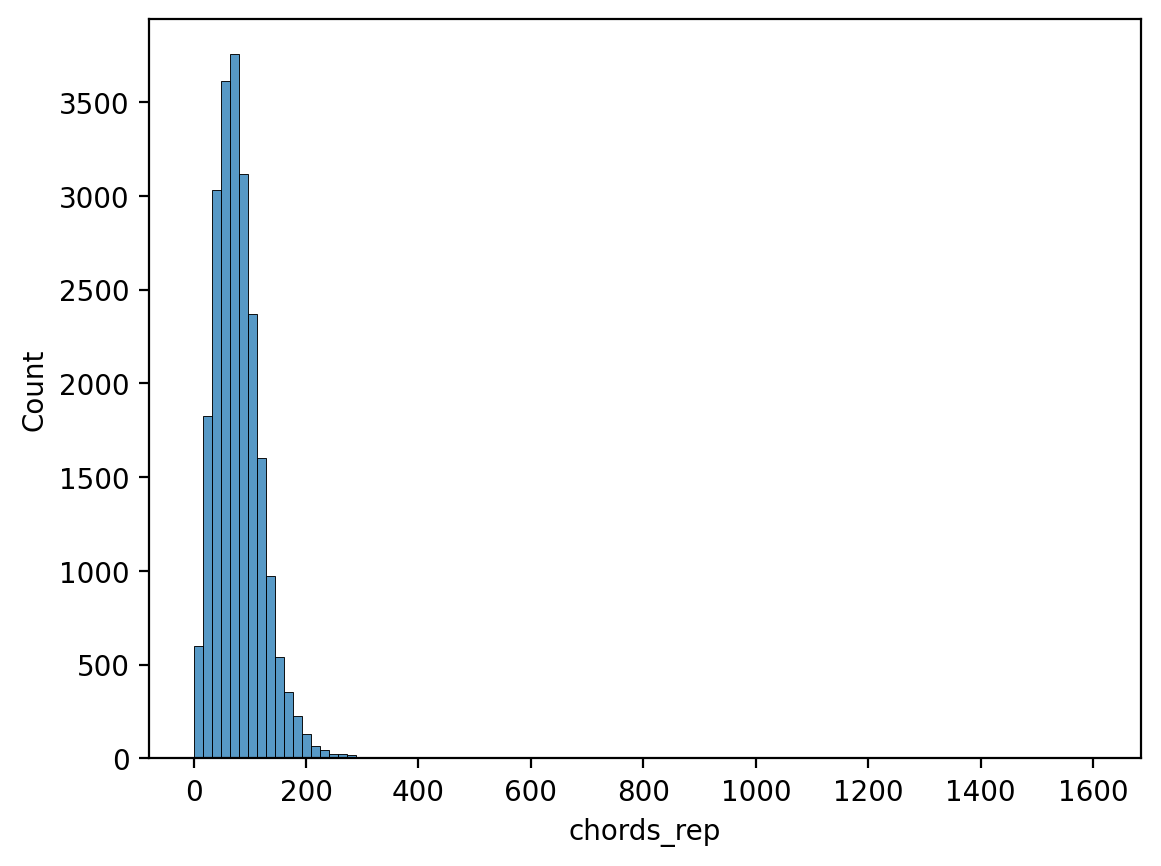

In [12]:
# Plot the distribution of the lengths of the chord sequences
sns.histplot(data["chords_rep"].apply(len), bins=100)

For efficiency during training, our models will accept padded sequences of a fixed length. Therefore, we will have to set margins on the allowed length of chord sequences. From the plot above, we can see that picking 256 as the fixed length covers most sequences. Since we will also encode the start and end of sequence tokens, the actual threshold will be 254. We will exclude sequences longer than this threshold, as well as one-chord sequences (as they do not provide meaningful information to the model).

In [13]:
# Drop the extremes
data = data[data["chords_rep"].apply(len) > 1]
data = data[data["chords_rep"].apply(len) < 255]

In [14]:
# Save the tokenized data
tokenized_data = data.copy()
tokenized_data = tokenized_data.drop(columns=["chords"])
tokenized_data = tokenized_data.rename(columns={"chords_rep": "chords"})
tokenized_data["chords"] = tokenized_data["chords"].apply(lambda x: json.dumps(x.tolist()))
tokenized_data.to_csv("Data/data_tokenized_pitch_class.csv", index=False)

## Unique Extension Tokenization

With this tokenization, we will assign a different token for each chord in the data (C/A will be different from C6, E# will be different from F). This tokenization will be useful for a machine translation model from the pitch class representation. Since transposing the chords would remove their desired modifications (sharps and flats would be ambiguous), only the original variant will be used.

It should be noted that with this method, the model will (after deployment) encounter chords that it has never seen (some variants, especially those including double sharps and double flats, are simply not present in this dataset). A blank chord token will be reserved for such cases.

In [15]:
# Load the data again, this time with already dropped extremes
data = data.drop(columns=["chords_rep"])
data.head()

,url,title,artist,decade,genre,ratings,stars,chords
0,https://tabs.ultimate-guitar.com/tab/jeff-buck...,Hallelujah,Jeff Buckley,1990,Rock|Folk,51639.0,5.0,C Am C Am C Am C Am F G C G C F G Am F G E7 Am...
1,https://tabs.ultimate-guitar.com/tab/ed-sheera...,Perfect,Ed Sheeran,2010,Pop,44194.0,5.0,G Em C D G Em C D G Em C G D G Em C D Em C G D...
2,https://tabs.ultimate-guitar.com/tab/elvis-pre...,Cant Help Falling In Love,Elvis Presley,1960,"Soundtrack|R&B, Funk & Soul",30059.0,5.0,C G Am F C G C Em Am F C G F G Am F C G C Em A...
3,https://tabs.ultimate-guitar.com/tab/eagles/ho...,Hotel California,Eagles,1970,Rock,28670.0,5.0,Bm F#7 A E G D Em F#7 Bm F#7 A E G D Em F#7 Bm...
4,https://tabs.ultimate-guitar.com/tab/radiohead...,Creep,Radiohead,1990,Rock,28606.0,5.0,G B C Cm G B C Cm G B C Cm G B C Cm G B C Cm G...


In [16]:
# Get all the unique chords and their corresponding tokens
all_chords = set()

for chords in data["chords"]:
    for chord in chords.strip().split(" "):
        all_chords.add(chord)
        
# Sort the chords for consistency
all_chords = sorted(list(all_chords))
chord_to_unique_token = {chord: i for i, chord in enumerate(all_chords)}

In [17]:
print(f"There are a total of {len(all_chords)} unique chords.")

There are a total of 1871 unique chords.


In [18]:
def tokenize_chords(chords):
    chords = [chord_to_unique_token[ch] for ch in chords.strip().split(" ")]
    return np.array(chords, dtype=np.int32)

data["chords_rep"] = data["chords"].apply(tokenize_chords)

In [19]:
data.head()

,url,title,artist,decade,genre,ratings,stars,chords,chords_rep
0,https://tabs.ultimate-guitar.com/tab/jeff-buck...,Hallelujah,Jeff Buckley,1990,Rock|Folk,51639.0,5.0,C Am C Am C Am C Am F G C G C F G Am F G E7 Am...,"[526, 216, 526, 216, 526, 216, 526, 216, 1319,..."
1,https://tabs.ultimate-guitar.com/tab/ed-sheera...,Perfect,Ed Sheeran,2010,Pop,44194.0,5.0,G Em C D G Em C D G Em C G D G Em C D Em C G D...,"[1581, 1248, 526, 769, 1581, 1248, 526, 769, 1..."
2,https://tabs.ultimate-guitar.com/tab/elvis-pre...,Cant Help Falling In Love,Elvis Presley,1960,"Soundtrack|R&B, Funk & Soul",30059.0,5.0,C G Am F C G C Em Am F C G F G Am F C G C Em A...,"[526, 1581, 216, 1319, 526, 1581, 526, 1248, 2..."
3,https://tabs.ultimate-guitar.com/tab/eagles/ho...,Hotel California,Eagles,1970,Rock,28670.0,5.0,Bm F#7 A E G D Em F#7 Bm F#7 A E G D Em F#7 Bm...,"[476, 1345, 0, 1066, 1581, 769, 1248, 1345, 47..."
4,https://tabs.ultimate-guitar.com/tab/radiohead...,Creep,Radiohead,1990,Rock,28606.0,5.0,G B C Cm G B C Cm G B C Cm G B C Cm G B C Cm G...,"[1581, 285, 526, 708, 1581, 285, 526, 708, 158..."


In [20]:
# Save the tokenized data
data = data.drop(columns=["chords"])
data = data.rename(columns={"chords_rep": "chords"})
data["chords"] = data["chords"].apply(lambda x: json.dumps(x.tolist()))
data.to_csv("Data/data_tokenized_unique.csv", index=False)

In [21]:
# Save the chord to unique token map
with open("Data/chord_to_unique_token.json", "w") as parser:
    json.dump(chord_to_unique_token, parser)